In [8]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Single-Head Self-Attention

Step-by-step bb - ignoring some details like standardization and dropout.

In [15]:
# toy example
torch.manual_seed(42)
    
# Let's assume we have a sequence of 4 tokens with embedding dimension 8
seq_len = 4
embed_dim = 8

# Create random embeddings to simulate a simple sentence
# In a real scenario, these would be the result of embedding words
x = torch.randn(seq_len, embed_dim)
print(f"Input tensor shape: {x.shape}")

# Sample token list for visualization
tokens = ["The", "cat", "sat", "down"]

Input tensor shape: torch.Size([4, 8])


In [17]:
Wq = nn.Linear(embed_dim, embed_dim, bias=False)  # query 
Wk = nn.Linear(embed_dim, embed_dim, bias=False)  # keys
Wv = nn.Linear(embed_dim, embed_dim, bias=False)  # values

These are the core building-blocks of the self-attention head. Each may learn *different things* during training.\
The nomenclature of "Queries" and "Keys" is irksome to me. Let's avoid reading into these meanings and just think about the mathematical relationships.

Each of these `Wq`, `Wk`, `Wv` are matrix representations of linear operators on a vector space of dimension `embed_dim`. This means that each maps the *coordinates* of the column vectors in `x` to a different set of *coordinates* in the same space.\
Through the process of training it is possible that the matrices come to represent linear projections into smaller subspaces of the full `embed_dim` dimensional vector space, but I think that in principal we begin with operators.


Here's the basic forward pass:
1. First, we take the compositions $W_q(x)$ and $W_k(x)$, effectively applying the linear operator mappings represented by both matrices on the input `x`. This is a linear transformation in the `embed_dim`-dimensional embedding space. So, each column vector (token) in `x` is taken to a different column vector within the same space.

2. Next, we multiply $W_q(x) \cdot W_k^\intercal(x)$. This is the inner-product (dot-product) of the query matrix and the dual map of the keys matrix. The result is an `seq_len x seq_len` matrix with elements corresponding to the dot-products betweent the column vectors of `Wq` and `Wk`. In other words, we get a matrix comprised of the dot-products between the $W_q(x)$ mappings in embedding space and the $W_k(x)$ mappings in embedding space. These dot-products reflect the cosine-similarity between the row vectors (token) of `Wq` and the column-vectors (tokens) `Wk`. So, large values represent greater similarities between the mappings.
    - This is conceptually significant. The mappings represented by `Wq` and the mappings represented by `Wk` are both learnable through backpropogation. This means that they may be learned *separately*. Thus, the cosine-similarity between the key-mapping for `'cat'` and the query-mapping for `'sat'` may be different from the cosine-similarity between the query-mapping for `'cat'` and the key-mapping for `'sat'`
        - This allows us to *"attend to"* tokens differently depending on whether they are query-mappings or key-mappings
        - This is significant because it *asymmetric* relationships
        - **This asymmetry will become clear once we apply *masking*** which prevents previous tokens from attending to future tokens
    - I will refer to this `seq_len x seq_len` matrix as the attention scores matrix denoted $A$
    - I will denote the `seq_len x embed_dim` matrices of query and key coordinates as $Q \coloneqq W_q(x)$ and $K \coloneqq W_k(x)$

3. Next, we apply *masking* to the the attention scores matrix $A$ such that only cosine similarities for previous tokens are included for each token. Specifically, when we wish to ensure that only past tokens are attended to, we have an ***Encoder*** architecture. Typically, this is done by setting the elements of the upper-triangle of $A$ to $-\infty$ (which map to $0$ via softmax in step 4).\
\
 I think the most effective way to conceptualize this is by considering each column-vector (token) in $Q$ and $K$. In terms of dot-products, we can think of row $j$ of $A$ as the dot products of the $j^{\text{th}}$ token-mapping in $Q$ with each token-mapping in $K^\intercal$. So, the attention scores matrix with masking will look like: $$
 A = \begin{bmatrix} 
 Q_{1, \cdot}\cdot K_{\cdot, 1} \ \ \ \ \ \ \ \ \ \ -\infty \ \ \ \ \ \ \ \ -\infty  \ \ \ \ -\infty \\
 Q_{2, \cdot}\cdot K_{\cdot, 1} \ \ \ \ \ Q_{2, \cdot}\cdot K_{\cdot, 2} \ \ \ \ \ \ -\infty \ \ \ \ -\infty \\
 Q_{3, \cdot}\cdot K_{\cdot, 1} \ \ \ \ \ Q_{3, \cdot}\cdot K_{\cdot, 2} \ \ \ \ Q_{3, \cdot}\cdot K_{\cdot, 3} \  -\infty \\
 Q_{4, \cdot}\cdot K_{\cdot, 1} \ \ Q_{4, \cdot}\cdot K_{\cdot, 2} \ \ Q_{4, \cdot}\cdot K_{\cdot, 3} \ \ Q_{4, \cdot}\cdot K_{\cdot, 4}
 \end{bmatrix}$$ 
 Here, $K$ should really be $K^\intercal$...........\
 So, each query mapping *only* is composed with the key mappings of sequence positions *less that or equal to* its own sequence position. I.e. $$A_{j,k} = Q_{j, \cdot} \cdot K^\intercal_{\cdot, k}: \ k \le j$$
 Now, consider the asymmetric relationships. The token-mapping in column-vector $K_{\cdot, 1}$ may *attend to* (i.e. learn relationships with) each token-mapping in the row-vectors $Q_{1, \cdot}, \cdots Q_{4, \cdot}$. However, the token-mapping in row-vector $Q_{1, \cdot}$ may *only* attend to (i.e. learn relationships with) the column-vector $K_{\cdot, 1}$

4. Next, we apply a softmax transformation *over the column-vectors* of $A$ to convert the dot-products in the attention score matrix $A$ into probability weights. This applies a non-linearity and also creates a "winner-take-most" maximization. It suppresses low similarity attention scores down towards $0$ while maximizing high similarity scores up towards $1$. The strength of this maximization for entries in column $k$ of $A$ is *wholly dependent upon* the values in column $k$. So, weak similarity scores may be inflated up towards $1$ is all the other similarity scores in column $k$ are even weaker! **THIS IS IMPORTANT** This ensures that meaningful relationships will be learned between each query-key-pair even when their initial mappings in embedding space have *low semantic similarity*.

5. Finally, we multiply the softmax-maximized masked attention scores matrix by the *value* matrix $V \coloneqq W_v(x)$. This value matrix *preserves* some of the original semantic information from the embedded token representation $x$.In a sense, the value matrix $V$ represents "what information" is passed forwards while $Q$ and $K$ represent "how much of each value" should be passed forwards. Now, in the backwards pass, the weights in the matrix representation of the value-map $W_v$ are updated in part by the attention in scores in $A$: $$W_v = W_v - \text{lr} \cdot \frac{\partial L}{\partial W_v} = W_v - \text{lr} \cdot \bigg(\frac{\partial L}{\partial \text{Output}} \cdot A\bigg) \cdot x^\intercal$$
This means that the *training signal* for $V$ is directly shaped by the attention patterns in $A$ despite $V$ itself having no direct influence on the attention patterns.\
In essence, the value matrix $V$ *learns* to create representations that, *when weighted according to the attention patterns* in $A$, produce effective outputs. If certains tokens receive higher attention weights, then the corresponding token-mappings in $W_v$ will be updated more aggressively. **BOOM**\
There is a feedback loop here:
    - If a token's value representation is useful, models learn to attend to it more
    - If attention to a token is consistently high, its value representation becomes more refined

In [ ]:
x = x  # (seq_len, embed_dim) -- assumes input x is already embedded

Q = Wq(x)  # (seq_len, embed_dim)
K = Wk(x)  # (seq_len, embed_dim)

attn_scores = Q @ K.T  # (seq_len, seq_len)

In [21]:
Q.shape, K.shape

(torch.Size([4, 8]), torch.Size([4, 8]))

In [22]:
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
# mask = mask.to(attention_scores.device)
mask

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [24]:
attn_scores.masked_fill(mask, float("-inf"))

tensor([[-0.2816,    -inf,    -inf,    -inf],
        [ 0.1424,  0.5089,    -inf,    -inf],
        [-0.2486, -0.2103,  1.8736,    -inf],
        [ 1.7076,  0.2708, -0.8280, -0.6255]], grad_fn=<MaskedFillBackward0>)

In [9]:
class SelfAttention(nn.Module):
    """
    A single self-attention head implementation from scratch.
    
    Args:
        embed_dim (int): The embedding dimension of the input sequence
        dropout (float, optional): Dropout probability. Default: 0.0
    """
    def __init__(self, embed_dim, dropout=0.0):
        super(SelfAttention, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Linear projections for Query, Key, and Value
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        
        # Scaling factor for dot products (prevents softmax saturation)
        self.scaling = float(embed_dim) ** -0.5
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, return_attention=False):
        """
        Forward pass of the self-attention mechanism.
        
        Args:
            x (Tensor): Input of shape [batch_size, seq_len, embed_dim]
            return_attention (bool): Whether to return attention weights
            
        Returns:
            Tensor: Output of shape [batch_size, seq_len, embed_dim]
            Tensor (optional): Attention weights of shape [batch_size, seq_len, seq_len]
        """
        batch_size, seq_len, embed_dim = x.size()
        
        # Step 1: Project input to queries, keys, and values
        # Each projection transforms the input embedding to a different "space"
        queries = self.query_proj(x)  # [batch_size, seq_len, embed_dim]
        keys = self.key_proj(x)       # [batch_size, seq_len, embed_dim]
        values = self.value_proj(x)   # [batch_size, seq_len, embed_dim]
        
        # Step 2: Calculate scaled dot-product attention
        # Compute similarity between queries and keys
        # Shape: [batch_size, seq_len, seq_len]
        attention_scores = torch.bmm(queries, keys.transpose(1, 2))
        
        # Step 3: Apply scaling to prevent softmax saturation
        # When dimension grows, dot products grow larger in magnitude
        # pushing softmax to regions with extremely small gradients
        attention_scores = attention_scores * self.scaling
        
        # Step 4: Apply softmax to get attention weights
        # This normalizes scores to form a probability distribution
        # Shape: [batch_size, seq_len, seq_len]
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Step 5: Apply dropout to attention weights
        attention_weights = self.dropout(attention_weights)
        
        # Step 6: Use attention weights to aggregate value vectors
        # This is a weighted sum of value vectors based on attention weights
        # Shape: [batch_size, seq_len, embed_dim]
        output = torch.bmm(attention_weights, values)
        
        if return_attention:
            return output, attention_weights
        return output


In [10]:
def visualize_attention(tokens, attention_weights):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        tokens (list): List of token strings
        attention_weights (Tensor): Attention weights tensor of shape [seq_len, seq_len]
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(attention_weights.detach().numpy(), cmap='viridis')
    
    # Add colorbar
    fig.colorbar(im, ax=ax)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    
    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            text = ax.text(j, i, f'{attention_weights[i, j].item():.2f}',
                           ha="center", va="center", color="black" if attention_weights[i, j] < 0.5 else "white")
    
    ax.set_title("Attention Weights")
    fig.tight_layout()
    plt.show()

In [11]:

# Example usage
def run_example():
    # Create a simple sequence of word embeddings (simplified for demonstration)
    # In practice, these would be word embeddings from a model like Word2Vec or BERT
    torch.manual_seed(42)  # For reproducibility
    
    # Let's assume we have a sequence of 4 tokens with embedding dimension 8
    batch_size = 1
    seq_len = 4
    embed_dim = 8
    
    # Create random embeddings to simulate a simple sentence
    # In a real scenario, these would be the result of embedding words
    x = torch.randn(batch_size, seq_len, embed_dim)
    
    # Sample token list for visualization
    tokens = ["The", "cat", "sat", "down"]
    
    # Initialize our self-attention module
    self_attention = SelfAttention(embed_dim=embed_dim, dropout=0.1)
    
    # Forward pass with attention weights returned
    output, attention_weights = self_attention(x, return_attention=True)
    
    print("Input shape:", x.shape)
    print("Output shape:", output.shape)
    print("Attention weights shape:", attention_weights.shape)
    
    # Squeeze the batch dimension for visualization (since batch_size=1)
    attention_weights = attention_weights.squeeze(0)
    
    # Print attention weights matrix
    print("\nAttention Weights Matrix:")
    print(attention_weights)
    
    # Visualize attention weights
    visualize_attention(tokens, attention_weights)
    
    # Demonstrate what self-attention is actually computing
    print("\nDetailed attention computation for token 'cat' (position 1):")
    print(f"Attention weights for 'cat': {attention_weights[1]}")
    print(f"'cat' attends to 'The' with weight: {attention_weights[1, 0]:.4f}")
    print(f"'cat' attends to 'cat' with weight: {attention_weights[1, 1]:.4f}")
    print(f"'cat' attends to 'sat' with weight: {attention_weights[1, 2]:.4f}")
    print(f"'cat' attends to 'down' with weight: {attention_weights[1, 3]:.4f}")
    
    # The output embedding for 'cat' is a weighted sum of value vectors
    value_vectors = self_attention.value_proj(x).squeeze(0)  # [seq_len, embed_dim]
    
    # Manually compute the weighted sum to demonstrate what's happening
    manual_output = torch.zeros(embed_dim)
    for i in range(seq_len):
        manual_output += attention_weights[1, i] * value_vectors[i]
    
    print("\nManual computation of output embedding for 'cat':")
    print(f"Calculated: {manual_output}")
    print(f"From model: {output.squeeze(0)[1]}")
    print(f"Match: {torch.allclose(manual_output, output.squeeze(0)[1], rtol=1e-5)}")

Input shape: torch.Size([1, 4, 8])
Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])

Attention Weights Matrix:
tensor([[0.2218, 0.1787, 0.3904, 0.3202],
        [0.1464, 0.2811, 0.2871, 0.3965],
        [0.3128, 0.0000, 0.1741, 0.2446],
        [0.1435, 0.3482, 0.3614, 0.2579]], grad_fn=<SqueezeBackward1>)


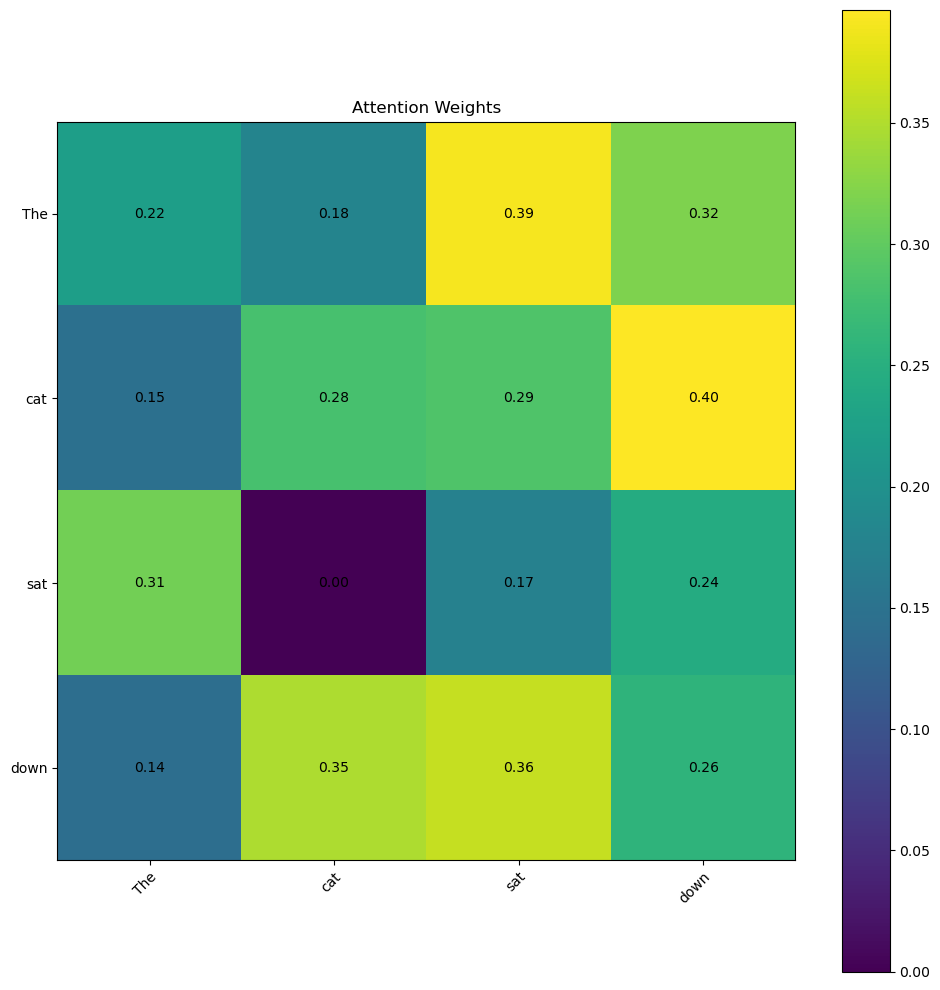


Detailed attention computation for token 'cat' (position 1):
Attention weights for 'cat': tensor([0.1464, 0.2811, 0.2871, 0.3965], grad_fn=<SelectBackward0>)
'cat' attends to 'The' with weight: 0.1464
'cat' attends to 'cat' with weight: 0.2811
'cat' attends to 'sat' with weight: 0.2871
'cat' attends to 'down' with weight: 0.3965

Manual computation of output embedding for 'cat':
Calculated: tensor([-0.0659,  0.1928,  0.5767, -0.9081,  0.3761, -0.2542,  0.0170,  0.4355],
       grad_fn=<AddBackward0>)
From model: tensor([-0.0659,  0.1928,  0.5767, -0.9081,  0.3761, -0.2542,  0.0170,  0.4355],
       grad_fn=<SelectBackward0>)
Match: True


In [12]:
run_example()